In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



### Importing Libraries

In [0]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

drive  sample_data


In [0]:
import os
os.chdir('drive/My Drive/EVA4/assignment7')

In [0]:
!ls

 8_final.ipynb	       dataloader.ipynb   map.jpg       S9_trial_album.ipynb
 9_final.ipynb	       dataset9.py	  model_7.py    testalbumentation.py
 albumentation.py      dataset.py	  model.py      trainalbumentation.py
 augmentation.py       final.ipynb	  __pycache__   training_new.py
'Copy of QuizDNN.py'   gradcam.py	  quiz9.ipynb   training.py
'Copy of S7.ipynb'     img1.png		  QuizDNN.py
 data		       __init__.py	  S7.ipynb


In [0]:
!pwd

/content/drive/My Drive/EVA4/assignment7


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from gradcam import *

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from dataset9 import Data
from model import Net, BasicBlock, ResNet, ResNet18, ResNet34
from training import train, test

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



### Downloading dataset

### Dataset and Creating Train/Test Split

In [0]:
data = Data()
trainset = data.getTrainDataSet(train=True)
testset = data.getTestDataSet(train=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: <testalbumentation.TestAlbumentation object at 0x7f85222bcac8>

### Dataloader Arguments & Test/Train Dataloaders

In [0]:
train_loader = data.getDataLoader(trainset)
test_loader = data.getDataLoader(testset)
test_grad_loader = data.getGradCamDataLoader(testset)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


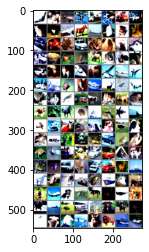

In [0]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



### Model Parameters

In [0]:
# dropout_value = 0.1

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# netobj = Net(dropout_value=0.1)
netobj = ResNet18()
model = netobj.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
        BasicBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
          Dropout-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
       BasicBlock-14           [-1

### Training and Testing Loss

In [0]:
from training import train_losses, test_losses, train_acc, test_acc

In [0]:
from torch.optim.lr_scheduler import StepLR


model =  netobj.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


EPOCHS = 50
for epoch in range(EPOCHS):
    if epoch > 6:
      scheduler.step()
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer,  epoch)
    test(model, device, test_loader)
print('Finished Training')

  0%|          | 0/391 [00:00<?, ?it/s]

lr=  0.1
EPOCH: 0


Loss=1.6844192743301392 Batch_id=390 Accuracy=33.85: 100%|██████████| 391/391 [00:30<00:00, 13.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 4666/10000 (46.66%)

lr=  0.1
EPOCH: 1


Loss=1.2453526258468628 Batch_id=390 Accuracy=54.08: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 5763/10000 (57.63%)

lr=  0.1
EPOCH: 2


Loss=1.0596909523010254 Batch_id=390 Accuracy=64.59: 100%|██████████| 391/391 [00:30<00:00, 14.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6866/10000 (68.66%)

lr=  0.1
EPOCH: 3


Loss=0.781039834022522 Batch_id=390 Accuracy=70.89: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7099/10000 (70.99%)

lr=  0.1
EPOCH: 4


Loss=0.457186222076416 Batch_id=390 Accuracy=75.19: 100%|██████████| 391/391 [00:30<00:00, 13.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7427/10000 (74.27%)

lr=  0.1
EPOCH: 5


Loss=0.5190365314483643 Batch_id=390 Accuracy=78.37: 100%|██████████| 391/391 [00:30<00:00, 13.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7625/10000 (76.25%)

lr=  0.1
EPOCH: 6


Loss=0.530703604221344 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7775/10000 (77.75%)

lr=  0.1
EPOCH: 7


Loss=0.5366147756576538 Batch_id=390 Accuracy=83.57: 100%|██████████| 391/391 [00:30<00:00, 13.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8052/10000 (80.52%)

lr=  0.1
EPOCH: 8


Loss=0.4703267514705658 Batch_id=390 Accuracy=85.64: 100%|██████████| 391/391 [00:30<00:00, 13.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7958/10000 (79.58%)

lr=  0.05
EPOCH: 9


Loss=0.2774271070957184 Batch_id=390 Accuracy=90.11: 100%|██████████| 391/391 [00:30<00:00, 13.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8483/10000 (84.83%)

lr=  0.05
EPOCH: 10


Loss=0.25891029834747314 Batch_id=390 Accuracy=91.84: 100%|██████████| 391/391 [00:29<00:00, 13.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8484/10000 (84.84%)

lr=  0.05
EPOCH: 11


Loss=0.2591060996055603 Batch_id=390 Accuracy=92.55: 100%|██████████| 391/391 [00:30<00:00, 13.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8509/10000 (85.09%)

lr=  0.025
EPOCH: 12


Loss=0.18827185034751892 Batch_id=390 Accuracy=95.47: 100%|██████████| 391/391 [00:30<00:00, 13.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8667/10000 (86.67%)

lr=  0.025
EPOCH: 13


Loss=0.13294263184070587 Batch_id=390 Accuracy=96.47: 100%|██████████| 391/391 [00:30<00:00, 13.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8671/10000 (86.71%)

lr=  0.025
EPOCH: 14


Loss=0.08143492043018341 Batch_id=390 Accuracy=96.95: 100%|██████████| 391/391 [00:30<00:00, 12.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8652/10000 (86.52%)

lr=  0.0125
EPOCH: 15


Loss=0.04846591502428055 Batch_id=390 Accuracy=98.20: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8742/10000 (87.42%)

lr=  0.0125
EPOCH: 16


Loss=0.04290010407567024 Batch_id=390 Accuracy=98.70: 100%|██████████| 391/391 [00:30<00:00, 13.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8728/10000 (87.28%)

lr=  0.0125
EPOCH: 17


Loss=0.030446046963334084 Batch_id=390 Accuracy=98.93: 100%|██████████| 391/391 [00:30<00:00, 13.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8701/10000 (87.01%)

lr=  0.00625
EPOCH: 18


Loss=0.014238923788070679 Batch_id=390 Accuracy=99.26: 100%|██████████| 391/391 [00:30<00:00, 13.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8749/10000 (87.49%)

lr=  0.00625
EPOCH: 19


Loss=0.014334666542708874 Batch_id=390 Accuracy=99.32: 100%|██████████| 391/391 [00:30<00:00, 13.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8720/10000 (87.20%)

lr=  0.00625
EPOCH: 20


Loss=0.023599565029144287 Batch_id=390 Accuracy=99.44: 100%|██████████| 391/391 [00:30<00:00, 13.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8747/10000 (87.47%)

lr=  0.003125
EPOCH: 21


Loss=0.014707297086715698 Batch_id=390 Accuracy=99.58: 100%|██████████| 391/391 [00:30<00:00, 13.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8759/10000 (87.59%)

lr=  0.003125
EPOCH: 22


Loss=0.006556290201842785 Batch_id=390 Accuracy=99.62: 100%|██████████| 391/391 [00:30<00:00, 13.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8769/10000 (87.69%)

lr=  0.003125
EPOCH: 23


Loss=0.010325705632567406 Batch_id=390 Accuracy=99.65: 100%|██████████| 391/391 [00:30<00:00, 13.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8758/10000 (87.58%)

lr=  0.0015625
EPOCH: 24


Loss=0.005436068866401911 Batch_id=390 Accuracy=99.68: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8755/10000 (87.55%)

lr=  0.0015625
EPOCH: 25


Loss=0.014503592625260353 Batch_id=390 Accuracy=99.65: 100%|██████████| 391/391 [00:30<00:00, 13.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8758/10000 (87.58%)

lr=  0.0015625
EPOCH: 26


Loss=0.018426543101668358 Batch_id=390 Accuracy=99.72: 100%|██████████| 391/391 [00:30<00:00, 14.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8754/10000 (87.54%)

lr=  0.00078125
EPOCH: 27


Loss=0.013304680585861206 Batch_id=390 Accuracy=99.71: 100%|██████████| 391/391 [00:30<00:00, 12.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8759/10000 (87.59%)

lr=  0.00078125
EPOCH: 28


Loss=0.018141204491257668 Batch_id=390 Accuracy=99.79: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8766/10000 (87.66%)

lr=  0.00078125
EPOCH: 29


Loss=0.005609297659248114 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [00:29<00:00, 13.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8767/10000 (87.67%)

lr=  0.000390625
EPOCH: 30


Loss=0.005063069052994251 Batch_id=390 Accuracy=99.77: 100%|██████████| 391/391 [00:30<00:00, 13.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8757/10000 (87.57%)

lr=  0.000390625
EPOCH: 31


Loss=0.008295655250549316 Batch_id=390 Accuracy=99.73: 100%|██████████| 391/391 [00:30<00:00, 13.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8746/10000 (87.46%)

lr=  0.000390625
EPOCH: 32


Loss=0.028423970565199852 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [00:30<00:00, 13.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8748/10000 (87.48%)

lr=  0.0001953125
EPOCH: 33


Loss=0.013268029317259789 Batch_id=390 Accuracy=99.75: 100%|██████████| 391/391 [00:30<00:00, 13.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8756/10000 (87.56%)

lr=  0.0001953125
EPOCH: 34


Loss=0.019835304468870163 Batch_id=390 Accuracy=99.78: 100%|██████████| 391/391 [00:30<00:00, 13.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8745/10000 (87.45%)

lr=  0.0001953125
EPOCH: 35


Loss=0.025380849838256836 Batch_id=390 Accuracy=99.77: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8758/10000 (87.58%)

lr=  9.765625e-05
EPOCH: 36


Loss=0.013473349623382092 Batch_id=390 Accuracy=99.78: 100%|██████████| 391/391 [00:30<00:00, 13.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8749/10000 (87.49%)

lr=  9.765625e-05
EPOCH: 37


Loss=0.007090359926223755 Batch_id=390 Accuracy=99.76: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8748/10000 (87.48%)

lr=  9.765625e-05
EPOCH: 38


Loss=0.005824250169098377 Batch_id=390 Accuracy=99.80: 100%|██████████| 391/391 [00:30<00:00, 13.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8761/10000 (87.61%)

lr=  4.8828125e-05
EPOCH: 39


Loss=0.00692561874166131 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [00:30<00:00, 13.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8749/10000 (87.49%)

lr=  4.8828125e-05
EPOCH: 40


Loss=0.025475895032286644 Batch_id=390 Accuracy=99.80: 100%|██████████| 391/391 [00:30<00:00, 13.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8751/10000 (87.51%)

lr=  4.8828125e-05
EPOCH: 41


Loss=0.01969139650464058 Batch_id=390 Accuracy=99.78: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8750/10000 (87.50%)

lr=  2.44140625e-05
EPOCH: 42


Loss=0.0384259894490242 Batch_id=390 Accuracy=99.76: 100%|██████████| 391/391 [00:30<00:00, 13.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8754/10000 (87.54%)

lr=  2.44140625e-05
EPOCH: 43


Loss=0.032743535935878754 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8754/10000 (87.54%)

lr=  2.44140625e-05
EPOCH: 44


Loss=0.022925948724150658 Batch_id=390 Accuracy=99.79: 100%|██████████| 391/391 [00:33<00:00, 13.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8749/10000 (87.49%)

lr=  1.220703125e-05
EPOCH: 45


Loss=0.008386468514800072 Batch_id=390 Accuracy=99.79: 100%|██████████| 391/391 [00:30<00:00, 13.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8766/10000 (87.66%)

lr=  1.220703125e-05
EPOCH: 46


Loss=0.009141260758042336 Batch_id=390 Accuracy=99.81: 100%|██████████| 391/391 [00:31<00:00, 12.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8749/10000 (87.49%)

lr=  1.220703125e-05
EPOCH: 47


Loss=0.010584336705505848 Batch_id=390 Accuracy=99.81: 100%|██████████| 391/391 [00:30<00:00, 13.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8759/10000 (87.59%)

lr=  6.103515625e-06
EPOCH: 48


Loss=0.017657184973359108 Batch_id=390 Accuracy=99.77: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8759/10000 (87.59%)

lr=  6.103515625e-06
EPOCH: 49


Loss=0.025208711624145508 Batch_id=390 Accuracy=99.75: 100%|██████████| 391/391 [00:30<00:00, 13.78it/s]



Test set: Average loss: 0.0040, Accuracy: 8754/10000 (87.54%)

Finished Training


Text(0, 0.5, 'Accuracy')

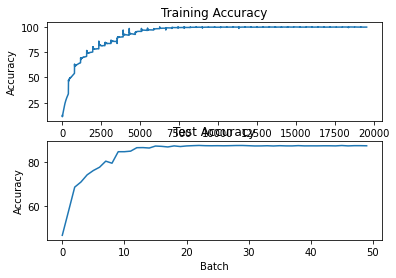

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  plane   cat horse   car


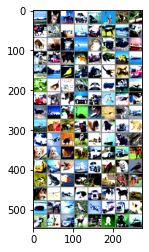

In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = model(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane   cat horse   car


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 87 %
Accuracy of   car : 91 %
Accuracy of  bird : 84 %
Accuracy of   cat : 57 %
Accuracy of  deer : 91 %
Accuracy of   dog : 77 %
Accuracy of  frog : 81 %
Accuracy of horse : 93 %
Accuracy of  ship : 93 %
Accuracy of truck : 96 %


In [0]:
# get the image from the dataloader
# testloader2 = transforme.testloader2
it = iter(test_grad_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


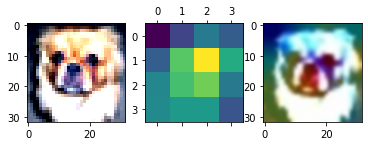

In [0]:
import gradcam
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


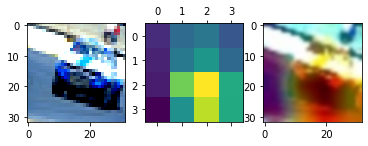

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


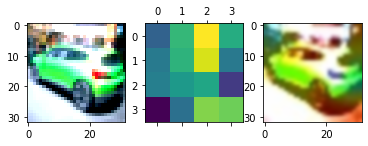

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


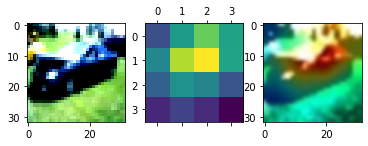

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


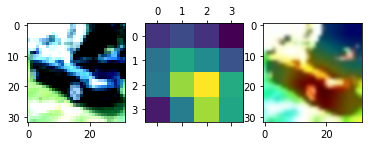

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


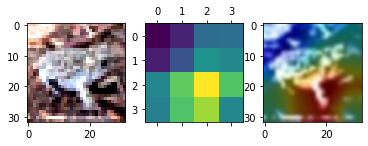

In [0]:
img,_ = next(it)
gradcam.gradcamof(model, img, classes)